<a href="https://colab.research.google.com/github/saharshasamudrala05/ML/blob/main/BERT_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import transformers

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from torch.optim import AdamW
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Sat May 10 05:30:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
###loading Cola Dataset

In [11]:
import requests
from PIL import Image
from io import BytesIO

def get_image_from_github(image_name):
  # The base URL of the image files in the GitHub repository
    base_url = 'https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/main/Notebook%20images/05/'

    response = requests.get(base_url + image_name)

    if response.status_code == 200:
      image = Image.open(BytesIO(response.content))

      return image

    else:
      print(f' error {response.status_code}: unable to access the imgage')
      return None

In [12]:
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter05/in_domain_train.tsv --output "in_domain_train.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0   919k      0 --:--:-- --:--:-- --:--:--  919k


In [13]:
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter05/out_of_domain_dev.tsv --output "out_of_domain_dev.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0  86600      0 --:--:-- --:--:-- --:--:-- 86644


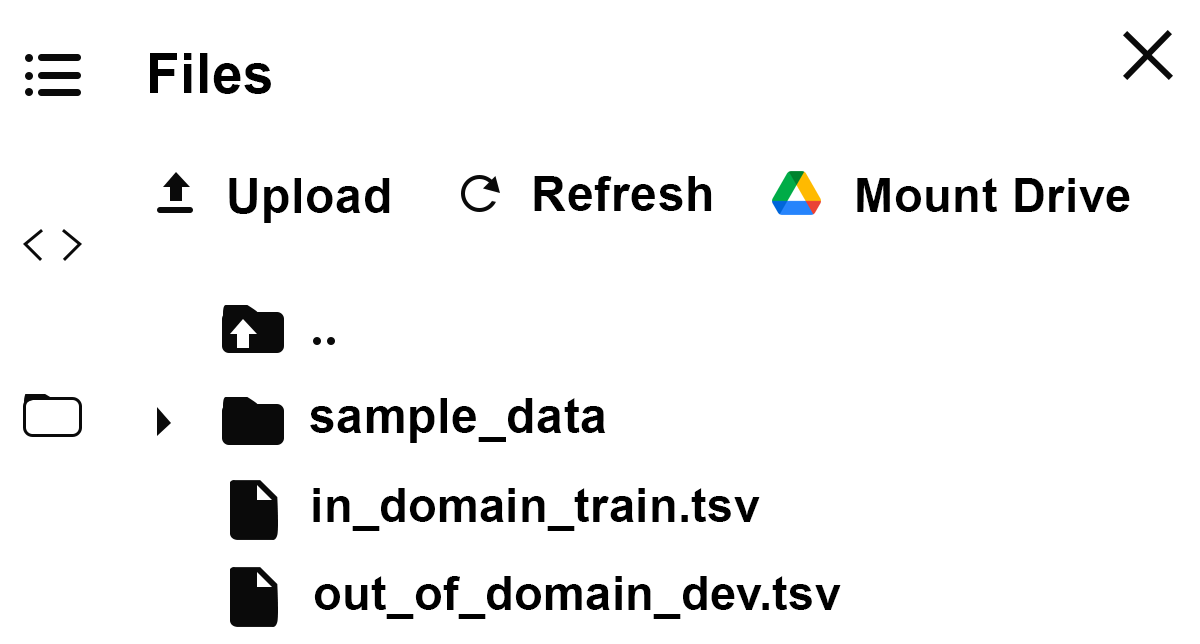

In [14]:
display(get_image_from_github('B19899_05_05.png') or print('Image not found'))

In [15]:
#source of dataset : https://nyu-mll.github.io/CoLA/
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
print(df.shape)

df.sample(10)

(8551, 4)


,sentence_source,label,label_notes,sentence
5554,b_73,1,NaN,they may grow as high as six feet .
1845,r-67,0,*,"we 'll go together , us ."
7291,sks13,1,NaN,my niece could more faithfully write me letters .
2981,l-93,0,*,the mona lisa sees easily .
640,bc01,1,NaN,give the baby the bottle full .
4947,ks08,1,NaN,"the contestant who won the first prize , who i..."
1555,r-67,1,NaN,"tom ordered bacon , and dick ordered lettuce ,..."
7949,ad03,1,NaN,lucy 's analysis was the most successful
8416,ad03,0,*,"who had poseidon run away , because the execut..."
6372,d_98,1,NaN,a soldier should be prepared to die for her co...


In [16]:
#creating sentences, labelLists, and adding BERT tokens

In [17]:
sentences = df.sentence.values

#Adding [cls] and [sep] at the beginning and end of the each sentence
sentences = ["[CLS]" + sentence + "[SEP]" for sentence in sentences]

labels = df.label.values

In [18]:
from transformers import BertTokenizer
try:
  tokenizer  = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  print("Tokenizer downloaded successfully")
except Exception as e:
  print("Error occured while downloading tokenizer")
  print(str(e))
  import traceback
  print(traceback.format_exc())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizer downloaded successfully


In [19]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print("Tokenize the first sentence:")
print(tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [20]:
MAX_LEN= 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(input_ids, maxlen= MAX_LEN, dtype="long", truncating="post", padding="post")

In [21]:
#Creating Attention Masks

In [22]:
attention_masks = []

#Creating a mask of 1s
for sequence in input_ids:
  seq_mask = [float(i>0) for i in sequence]
  attention_masks.append(seq_mask)

In [23]:
train_inputs, validation_inputs, train_labels, validation_labels= train_test_split(input_ids, labels, random_state = 2018, test_size=0.1)
train_masks, validation_masks, _,_ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)


In [24]:
###converting data into torch tensors

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [25]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_labels, train_masks)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_labels, validation_masks)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size=batch_size)

In [26]:
### BERT model Configuration

#initializing a BERT bert-base-uncased style configuration
from transformers import BertModel, BertConfig

configuration = BertConfig()

#Initializing a model from the bert-base-uncased style configuration

model = BertModel(configuration)

#accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "_attn_implementation_autoset": true,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [27]:
### Loading the huggingface BERT uncased base model

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = nn.DataParallel(model)
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=7

In [28]:
### Optimizer Grouped Parameters

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)

In [29]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
# Separate the `weight` parameters from the `bias` parameters.
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01.
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0.
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},

    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [30]:
#Displaying the sample parameter_optimizer: Layer 3

layer_parameters = [p for n,p in model.named_parameters() if 'layer.3' in n]
print(layer_parameters)

[Parameter containing:
tensor([[ 0.0586, -0.0279,  0.0022,  ..., -0.0205,  0.0419,  0.0560],
        [-0.0011,  0.1283, -0.0564,  ..., -0.0514, -0.0199,  0.0516],
        [-0.0083,  0.0060, -0.0469,  ...,  0.0569, -0.0073, -0.0616],
        ...,
        [ 0.0118,  0.0645, -0.0159,  ..., -0.0027, -0.0031, -0.0141],
        [ 0.0029,  0.0531,  0.0221,  ..., -0.0047,  0.0399,  0.0344],
        [ 0.0512,  0.0246,  0.0077,  ...,  0.0108,  0.0262,  0.0081]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 9.7401e-02, -1.9291e-01,  4.3323e-02,  1.7938e-01, -8.0236e-02,
         2.4005e-01, -1.1202e-01, -7.8751e-02,  1.3820e-01, -2.4162e-01,
         1.9788e-01, -3.2046e-01,  3.5266e-02,  5.7152e-01, -5.9514e-02,
        -2.5558e-02,  9.7958e-02, -4.7495e-02, -2.0452e-01,  3.0384e-04,
         3.0269e-01,  4.9826e-02, -2.9197e-02,  2.3859e-01,  1.9353e-01,
         1.0818e-01,  2.7912e-01,  6.2726e-02, -1.7285e-01,  4.8728e-02,
         1.9279e-02, -6.0480e-01,  3.9

In [31]:
no_decay #Displaying no.of parameters for which weight decay is not applied

['bias', 'LayerNorm.weight']

In [32]:
# Displaying the list of the two dictionaries
small_sample = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)][:2],
     'weight_decay_rate': 0.1},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)][:2],
     'weight_decay_rate': 0.0}
]

for i, group in enumerate(small_sample):
    print(f"Group {i+1}:")
    print(f"Weight decay rate: {group['weight_decay_rate']}")
    for j, param in enumerate(group['params']):
        print(f"Parameter {j+1}: {param}")

Group 1:
Weight decay rate: 0.1
Parameter 1: Parameter containing:
tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
       device='cuda:0', requires_grad=True)
Parameter 2: Parameter containing:
tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
          6.8312e-04,  1.5441e-02],
        [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
          2.9753e-02, -5.3247e-03],
        [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
          1.8741e-02, -7.3140e-03],
        ...,
        [ 1.7418e-02,  3.4903e-03, -9.5621e-03,  ...,  2.9599e-03,
          4.3435e-04, -2.6949e-

In [33]:
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters, lr= 2e-5, eps = 1e-8)

total_steps = len(train_dataloader) * epochs

#Create a learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps = total_steps)

In [34]:
### Create an Accuracy Measurement Function, to calculate the accuracy of predictions vs labels
def flat_accuracy(pred, labels):
  pred_flat = np.argmax(pred, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat)/ len(labels_flat)

In [35]:
t = []

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_labels,  b_input_mask = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_labels, b_input_mask = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5272559602725555


Epoch:  25%|██▌       | 1/4 [02:24<07:13, 144.47s/it]

Validation Accuracy: 0.8059413580246914
Train loss: 0.31350503036466376


Epoch:  50%|█████     | 2/4 [04:52<04:52, 146.30s/it]

Validation Accuracy: 0.8236882716049382
Train loss: 0.1800164928605695


Epoch:  75%|███████▌  | 3/4 [07:19<02:27, 147.03s/it]

Validation Accuracy: 0.8279320987654322
Train loss: 0.11190215780310858


Epoch: 100%|██████████| 4/4 [09:47<00:00, 146.95s/it]

Validation Accuracy: 0.8302469135802469


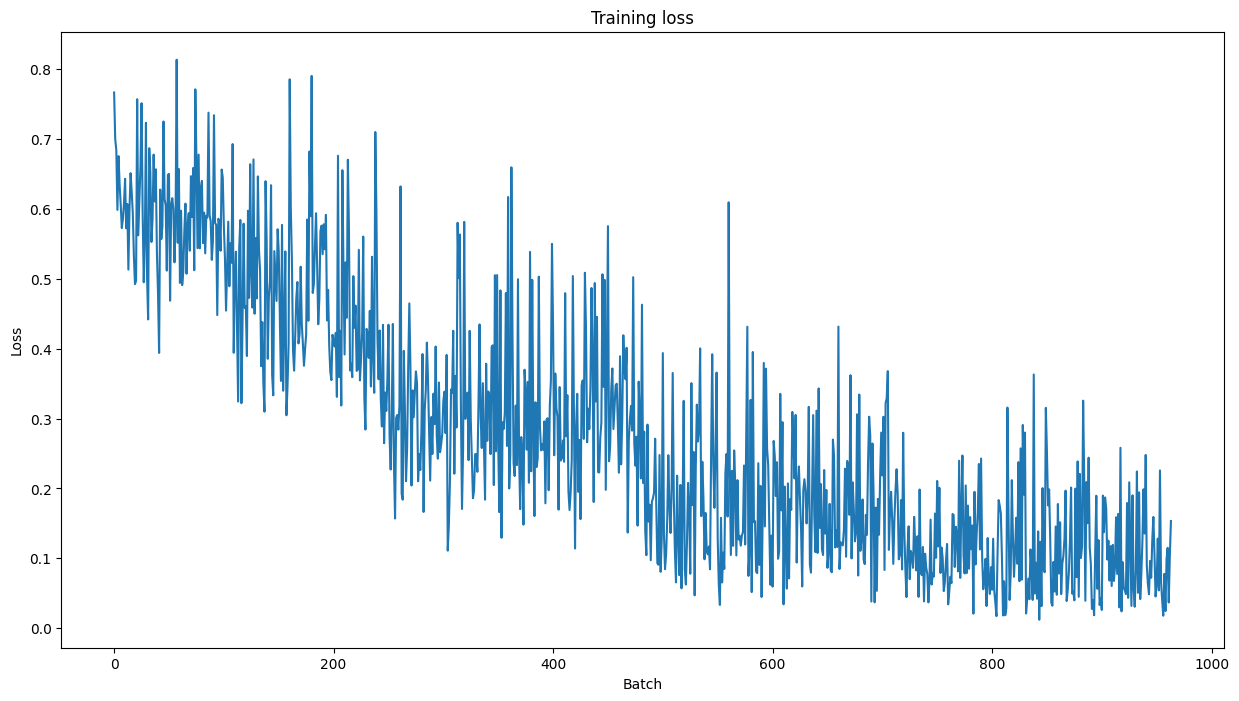

In [36]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [37]:
#loading the holdout dataset
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])


In [38]:
df.shape

(516, 4)

In [39]:
#Create sentence and label lists
sentences = df.sentence.values

#We need to add the special tokens at the beginning and the end of each sentences  for BERT to work properly
sentences = ["['CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [40]:
#Softmax Logits

import numpy as np

def softmax(logits):
  e = np.exp(logits)
  return e / np.sum(e)

In [41]:
import torch
import numpy as np

#putting model in evaluation method

model.eval()

#Tracking Variables
raw_predictions, predicted_classes, true_labels = [], [], []

#Predict
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  #unpack the inputs from the dataloader
  b_input_ids, b_input_mask, b_labels = batch
  #Telling the model not to compute or store gradients
  with torch.no_grad():
    #calculate forwardpass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids= None, attention_mask=b_input_mask, labels= b_labels)

    #Moving logits and labels to CPU
    logits = outputs['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    #convert input)ids back to words
    b_input_ids = b_input_ids.to('cpu').numpy()
    batch_sentences = [tokenizer.decode(input_ids, skip_special_tokens=True) for input_ids in b_input_ids]

    #Apply softmax to convert logits into probabilities
    probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)

    #The predicted class is the one with highest probability
    batch_predictions = np.argmax(probabilities, axis=1)

    #Print the sentemnces and the corresponding predictions for this batch
    for i, sentence in enumerate(batch_sentences):
      print(f"Sentence: {sentence}")
      print(f"predictions: {logits[i]}")
      print(f"Sofmax probabilities", softmax(logits[i]))
      print(f"Prediction: {batch_predictions[i]}")
      print(f"True label: {label_ids[i]}")

    # Store raw predictions, predicted classes and true labels
    raw_predictions.append(logits)
    predicted_classes.append(batch_predictions)
    true_labels.append(label_ids)

Sentence: ['cls ] somebody just left - guess who.
predictions: [-0.7333947   0.75129104]
Sofmax probabilities [0.18472071 0.8152793 ]
Prediction: 1
True label: 1
Sentence: ['cls ] they claimed they had settled on something, but it wasn't clear what they had settled on.
predictions: [-1.1309156  1.4185307]
Sofmax probabilities [0.07246369 0.9275363 ]
Prediction: 1
True label: 1
Sentence: ['cls ] if sam was going, sally would know where.
predictions: [-0.9173949  1.0605613]
Sofmax probabilities [0.12153689 0.87846315]
Prediction: 1
True label: 1
Sentence: ['cls ] they're going to serve the guests something, but it's unclear what.
predictions: [-1.2766292  1.7466364]
Sofmax probabilities [0.04638582 0.9536142 ]
Prediction: 1
True label: 1
Sentence: ['cls ] she's reading. i can't imagine what.
predictions: [-0.5506552   0.80013126]
Sofmax probabilities [0.20574182 0.7942582 ]
Prediction: 1
True label: 1
Sentence: ['cls ] john said joan saw someone from her graduating class.
predictions: [-

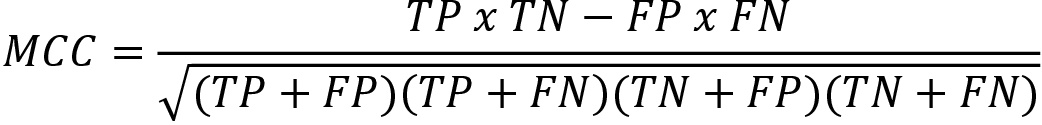

In [42]:
display(get_image_from_github('B19899_05_005.png') or print('Image not found'))

In [43]:
from sklearn.metrics import matthews_corrcoef

# Initialize an empty list to store the Matthews correlation coefficient for each batch
matthews_set = []

# Iterate over each batch
for i in range(len(true_labels)):
  # Calculate the Matthews correlation coefficient for this batch

  # true_labels[i] are the true labels for this batch
  # predicted_classes[i] are the predicted classes for this batch
  # We don't need to use np.argmax because predicted_classes already contains the predicted classes

  matthews = matthews_corrcoef(true_labels[i], predicted_classes[i])

  # Add the result to our list
  matthews_set.append(matthews)

# Now matthews_set contains the Matthews correlation coefficient for each batch

Matthews Correlation Coefficient evaluation for the whole dataset

In [44]:
from sklearn.metrics import matthews_corrcoef

# Flatten the true_labels and predicted_classes list of lists into single lists
true_labels_flattened = [label for batch in true_labels for label in batch]
predicted_classes_flattened = [pred for batch in predicted_classes for pred in batch]

# Calculate the MCC for the entire set of predictions
mcc = matthews_corrcoef(true_labels_flattened, predicted_classes_flattened)

print(f"MCC: {mcc}")

MCC: 0.47822324071222966


In [45]:
# Specify a directory to save your model and tokenizer
save_directory = "/content/model"


# If your model is wrapped in DataParallel, access the original model using .module and then save
if isinstance(model, torch.nn.DataParallel):
    model.module.save_pretrained(save_directory)
else:
    model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

('/content/model/tokenizer_config.json',
 '/content/model/special_tokens_map.json',
 '/content/model/vocab.txt',
 '/content/model/added_tokens.json')

## Creating an interface for the trained model

In [46]:
# mount Google Drive, for example, or other source
#from google.colab import drive
#drive.mount('/content/drive')


In [47]:
#from google.colab import drive
#drive.mount('/content/drive')

In [48]:

!mkdir -p /content/model/model/

! cp drive/MyDrive/files/model_C5/*.* /content/model

#install transformers
!pip install Transformers

from transformers import BertTokenizer, BertForSequenceClassification

# Directory where the model and tokenizer were saved
load_directory = "/content/model/"

# Load the model
model = BertForSequenceClassification.from_pretrained(load_directory)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

cp: cannot stat 'drive/MyDrive/files/model_C5/*.*': No such file or directory


In [49]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

model.eval()  # set the model to evaluation mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [50]:
# building the prediction function

In [52]:
def predict(sentence, model, tokenizer):
    # Add [CLS] and [SEP] tokens
    sentence = "[CLS] " + sentence + " [SEP]"
    # Tokenize the sentence
    tokenized_text = tokenizer.tokenize(sentence)

    # Convert token to vocabulary indices
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    # Define a segment id (0 for all tokens; we don't have a second sequence)
    segments_ids = [0] * len(tokenized_text)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    # Make prediction
    with torch.no_grad():
        outputs = model(tokens_tensor, token_type_ids=segments_tensors)
        logits = outputs.logits
        # You might want to convert logits to probabilities or extract the predicted label.
        predicted_label = torch.argmax(logits, dim=1).item()

    return predicted_label


In [53]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00


In [54]:
import ipywidgets as widgets
from IPython.display import display

def model_predict_interface(sentence):
    prediction = predict(sentence, model, tokenizer)
    if prediction == 0:
        return "Grammatically Incorrect"
    elif prediction == 1:
        return "Grammatically Correct"
    else:
        return f"Label: {prediction}"

text_input = widgets.Textarea(
    placeholder='Type something',
    description='Sentence:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='50px')  # Adjust width and height here
)

output_label = widgets.Label(
    value='',
    layout=widgets.Layout(width='100%', height='25px'),  # Adjust width and height here
    style={'description_width': 'initial'}
)

def on_text_submit(change):
    output_label.value = model_predict_interface(change.new)

text_input.observe(on_text_submit, names='value')

display(text_input, output_label)

Textarea(value='', description='Sentence:', layout=Layout(height='50px', width='100%'), placeholder='Type some…

Label(value='', layout=Layout(height='25px', width='100%'), style=DescriptionStyle(description_width='initial'…